# Load

In [1]:
import io
import logging
import math
import sys
import pandas as pd
from typing import Tuple, get_args
from py_ballisticcalc import Ammo, Atmo, Vacuum, Shot, Calculator, HitResult
from py_ballisticcalc import ZeroFindingError, RangeError, TrajFlag, BaseEngineConfigDict, SciPyEngineConfigDict
from py_ballisticcalc import TableG1, logger
from py_ballisticcalc.drag_model import DragModel
from py_ballisticcalc.helpers import must_fire, find_index_for_time_point
from py_ballisticcalc.unit import *
from py_ballisticcalc.interface import _EngineLoader
logger.setLevel(logging.DEBUG)
print("\nAvailable engines: " + str(sorted([e.name for e in _EngineLoader.iter_engines()])))
PreferredUnits.drop = Distance.Feet
PreferredUnits.distance = Distance.Feet


Available engines: ['cythonized_euler_engine', 'cythonized_rk4_engine', 'euler_engine', 'rk4_engine', 'scipy_engine', 'verlet_engine']


# Vacuum Trajectory

Here is a convenient vacuum scenario so that we can check engine precision against a known exact solution.  A vacuum ballistic trajectory is a simple parabola, but the integration engines don't know that, so they attack it as they would even the most complicated ballistic scenario.

In [2]:
from py_ballisticcalc.helpers import solve_velocity_for_vacuum_time_to_zero, vacuum_time_to_zero, vacuum_range
cGravityConstant: float = -32.17405  # feet per second^2
launch_angle_deg = 30.0
launch_angle_rad = math.radians(launch_angle_deg)
time_to_zero = 60.0  # seconds
launch_velocity_fps = solve_velocity_for_vacuum_time_to_zero(time_to_zero=time_to_zero, launch_angle_deg=launch_angle_deg, gravity=-cGravityConstant)
time = vacuum_time_to_zero(velocity=launch_velocity_fps, launch_angle_deg=launch_angle_deg, gravity=-cGravityConstant)
range_to_zero = vacuum_range(velocity=launch_velocity_fps, angle_in_degrees=launch_angle_deg, gravity=-cGravityConstant)
print(f'{time} seconds to return to zero, launching at {launch_velocity_fps}fps with {launch_angle_deg} degrees.  '
      f'Range={range_to_zero:.4f}ft.')

def check_error(hit: HitResult, output: bool = False) -> float:
    z_down = hit.flag(TrajFlag.ZERO_DOWN)
    if z_down is not None and output:
        print(f'ZERO_DOWN: {z_down.time}s to ({z_down.distance >> Distance.Feet}, {z_down.height >> Distance.Feet}).')
    chkpt = hit.get_at_distance(Distance.Feet(range_to_zero))
    if chkpt is not None:
        chk_x = chkpt.distance >> Distance.Feet
        chk_h = chkpt.height >> Distance.Feet
        chk_err = math.sqrt((chk_x-range_to_zero)**2 + chk_h**2)
        if output:
            print(f'At {chkpt.time}s: ({chk_x}, {chk_h})ft ==> Error = {chk_err:.8f}ft')
        return chk_err
    return float('inf')

summary = []

60.0 seconds to return to zero, launching at 1930.4430000000002fps with 30.0 degrees.  Range=100308.7607ft.


# SciPy

Here's a simple example to show what we're working with:

In [3]:
config = SciPyEngineConfigDict(
        cMinimumVelocity=0,
        cMinimumAltitude=-1,
        integration_method="LSODA",
)
calc = Calculator(config, engine='scipy_engine')
shot = Shot(ammo=Ammo(DragModel(bc=0.759, drag_table=TableG1), Velocity.FPS(launch_velocity_fps)), atmo=Vacuum())
shot.relative_angle = Angular.Degree(launch_angle_deg)
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
check_error(hit, True)
hit.dataframe(True).drop(columns=['windage', 'slant_height', 'drop_adj', 'windage_adj', 'slant_distance', 'density_factor', 'drag', 'energy', 'ogw'])

INFO:py_balcalc:Loaded calculator from: py_ballisticcalc:SciPyIntegrationEngine (Class: <class 'py_ballisticcalc.engines.scipy_engine.SciPyIntegrationEngine'>)
DEBUG:py_balcalc:SciPy integration via LSODA done with 16 function calls.


ZERO_DOWN: 59.9999999999988s to (100308.7607134686, 1.3404160230204362e-12).
At 59.9999999999988s: (100308.7607134686, 1.3404160230204362e-12)ft ==> Error = 0.00000000ft


,time,distance,velocity,mach,height,angle,flag
0,0.000 s,0.00 ft,1930.4 ft/s,1.73 mach,0.00 ft,30.0000 °,ZERO_UP|RANGE
1,30.000 s,50154.38 ft,1671.8 ft/s,1.58 mach,14478.32 ft,0.0000 °,APEX
2,60.000 s,100308.76 ft,1930.4 ft/s,1.73 mach,0.00 ft,-30.0000 °,ZERO_DOWN|RANGE


Here's the function we'll use to test the `SciPyIntegrationEngine`:

In [3]:
def scipy_chk(timeit: bool = False, **kwargs):
    config = SciPyEngineConfigDict(
        cMinimumVelocity=0,
        cMinimumAltitude=-1,
        **kwargs,
    )
    calc = Calculator(config, engine='scipy_engine')
    shot = Shot(ammo=Ammo(DragModel(bc=0.759, drag_table=TableG1), Velocity.FPS(launch_velocity_fps)), atmo=Vacuum())
    shot.relative_angle = Angular.Degree(launch_angle_deg)
    t = calc.fire(shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
    err = check_error(t, False)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o calc.fire(shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
        return err, evals, speed.average
    return err, evals
logger.setLevel(logging.WARNING)
err, count, speed = scipy_chk(timeit=True, integration_method="LSODA")
print(f'Error={err:.8f}ft.  Integration steps: {calc.integration_step_count}.  Speed: {speed:.5f}s')

2.16 ms ± 99 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Error=0.00000000ft.  Integration steps: 12992.  Speed: 0.00216s


### Integration Methods

We identified 6 SciPy integration methods suitable for this sort of problem.  We'll test each using the default engine error tolerances.

In [5]:
from py_ballisticcalc.engines.scipy_engine import INTEGRATION_METHOD
stdout = sys.stdout  # Capture stdout because timeit prints to it
sys.stdout = io.StringIO()
for method in get_args(INTEGRATION_METHOD):
    err, count, speed = scipy_chk(timeit=True, integration_method=method)
    summary.append(('SciPy', method, err, count, speed))
sys.stdout = stdout
pd.DataFrame(summary, columns=['Engine', 'Setting', 'Error (ft)', 'Integration Steps', 'Speed']).sort_values(by='Error (ft)', ascending=True)

,Engine,Setting,Error (ft),Integration Steps,Speed
0,SciPy,RK23,5.456968e-12,23,0.002735
3,SciPy,Radau,1.466516e-11,53,0.004366
1,SciPy,RK45,5.823608e-11,32,0.002592
2,SciPy,DOP853,1.891836e-10,77,0.003361
5,SciPy,LSODA,1.993613e-09,16,0.001953
4,SciPy,BDF,1.884764e-07,58,0.006946


### Points computed

We can actually look at the points evaluated by SciPy: Uncomment `diff_eq()::self.eval_points.append(t)` in `scipy_engine.py`.  We'll see something interesting when we use LSODA: It appears that it is evaluating the first two steps *twice*.

We must remember that the function being solved is not just `f(t)`, but `f(t, s)`, where `s` is the state vector `[x, y, z, vx, vy, vz]`.

**Even if the time `t` is identical, the state `s` is different.**

Here are the primary reasons why a solver like LSODA would evaluate `f(t, s)` with the same `t` but a different `s`:

1.  **Jacobian Calculation (for Stiff Problems):** LSODA can switch to a stiff solver (BDF). To do this, it needs to compute the Jacobian matrix, which tells it how the derivative changes with respect to the state (`df/ds`). It computes this numerically by slightly perturbing each component of the state vector `s` and re-evaluating the function. All of these evaluations happen at the *same time `t`* but with slightly different state vectors `s`.

2.  **Error Estimation:** Some adaptive methods (though more common in Runge-Kutta methods) estimate the error by comparing the results of two different calculations that end at the same time `t`. This inherently requires multiple evaluations at intermediate points that can sometimes coincide in time.

3.  **Corrector Iterations (for Stiff Solvers):** Stiff solvers often use a "predictor-corrector" method. They predict a new state and then iterate to "correct" it until it converges. These correction iterations all happen at the same future time point `t`, but the state `s` is refined with each iteration, requiring a new function evaluation.

In [ ]:
config = SciPyEngineConfigDict(
    cMinimumVelocity=0,
    cMinimumAltitude=-1,
    relative_tolerance=1e-12,
    absolute_tolerance=1e-8,
    integration_method="LSODA",
)
calc = Calculator(config, engine='scipy_engine')
shot = Shot(ammo=Ammo(DragModel(bc=0.759, drag_table=TableG1), Velocity.FPS(launch_velocity_fps)), atmo=Vacuum())
shot.relative_angle = Angular.Degree(launch_angle_deg)
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
calc.eval_points  # Uncomment diff_eq()::self.eval_points.append(t) in scipy_engine.py to see eval points

[0.0,
 5.968364397369551e-06,
 5.968364397369551e-06,
 1.1936728794739102e-05,
 1.1936728794739102e-05,
 0.059695580702490245,
 0.11937922467618575,
 0.17906286864988125,
 0.7758993083868364,
 1.3727357481237914,
 1.9695721878607464,
 7.937936585230297,
 13.906300982599848,
 19.8746653799694,
 79.55830935366491]

### Tolerance

The SciPy solver works until it satisfies the least demanding error tolerance (between _relative_ and _absolute_). The most demanding error tolerance is just over 1e-14.  As we can see in the results from the next block: with relative tolerance set near the maximum, the absolute tolerance (`atol`) doesn't require more steps to reduce error until `atol < 1e-8`.

In [15]:
results = []
method = 'RK45'
# Run with rtol as limiting factor
rtol = 1e-1
atol = 1e-10
while rtol > 1e-10:
    rtol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    results.append((atol, rtol, err, count))
# Run with atol as limiting factor
atol = 1e-1
rtol = 1e-12
while atol > 1e-10:
    atol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    results.append((atol, rtol, err, count))
pd.DataFrame(results, columns=['Absolute Tolerance', 'Relative Tolerance', 'Error (ft)', 'Integration Steps'])#.sort_values(by='Error (ft)', ascending=False).sort_values(by='Integration Steps', ascending=True)

,Absolute Tolerance,Relative Tolerance,Error (ft),Integration Steps
0,1.000000e-10,1.000000e-02,4.729372e-11,86
1,1.000000e-10,1.000000e-03,1.001973e-10,80
2,1.000000e-10,1.000000e-04,4.688090e-11,74
3,1.000000e-10,1.000000e-05,7.730705e-11,68
4,1.000000e-10,1.000000e-06,6.821210e-11,62
5,1.000000e-10,1.000000e-07,1.155166e-10,56
6,1.000000e-10,1.000000e-08,4.092726e-11,50
7,1.000000e-10,1.000000e-09,6.442022e-11,44
8,1.000000e-10,1.000000e-10,7.912604e-11,38
9,1.000000e-10,1.000000e-11,3.637979e-11,38


But something counterintuitive is going on: In this test when we fix `atol=1e-10` we observe that the solver uses _fewer_ function evaluations as `rtol` _decreases_ from 1e-2 to 1e-10.  In general, decreasing `rtol` (holding all else constant) demands more precision from the solver and so should force the solver to take smaller steps, thus _increasing_ the number of function evaluations.

Here’s a breakdown of what is likely happening:

#### The Interaction of Tolerances and Step-Size Control

The solver's goal at each step is to keep the estimated local error (`err_est`) below a threshold:

`err_est <= atol + rtol * |y|`

It then uses this relationship to decide the size of the *next* step. A simplified view of the logic is:

1.  Take a trial step.
2.  Estimate the error `err_est`.
3.  If the error is too large, reject the step, shrink the step size, and try again.
4.  If the error is acceptable, accept the step.
5.  Calculate an "optimal" size for the *next* step based on the error from the current one. The goal is to make the next step as large as possible while still meeting the tolerance.

#### The Counter-Intuitive Behavior Here

In this experiment, `atol` is fixed at a very small `1e-10`.

1.  **When `rtol` is large (e.g., `1e-2`):**
    *   The total allowed error (`atol + rtol * |y|`) is quite large and dominated by the `rtol` term.
    *   The solver's step-size controller is encouraged to take very large steps.
    *   It might "overshoot" significantly, trying a huge step. The error estimate for this large step will also be large. The controller might then have to reject the step and retry with a smaller one. This process of trying a big step, failing, and retrying with smaller steps can lead to a higher total number of function evaluations.

2.  **When `rtol` is smaller (e.g., `1e-8`):**
    *   The total allowed error is now much smaller.
    *   The step-size controller is immediately more conservative. It doesn't even *attempt* the huge, optimistic steps it tried before.
    *   It starts with and continues to propose more reasonably sized steps. Because these steps are more likely to be accepted on the first try (without rejection), the total number of function evaluations can actually go down.

Here we are essentially seeing a transition from a "sloppy and aggressive" strategy to a "cautious and efficient" one.

| `rtol` | Solver Strategy | Step Rejections | Function Evaluations |
| :--- | :--- | :--- | :--- |
| **Large** | Tries very large, optimistic steps. | High (many steps are rejected and retried) | **Higher** |
| **Small** | Tries smaller, more conservative steps. | Low (most steps are accepted on first try) | **Lower** |

This is not a universal rule and is highly dependent on the specific solver (`RK45` in this case), the smoothness of the problem (a vacuum trajectory is extremely smooth), and the specific values of `atol` and `rtol`.

We can inspect the actual points being attempted to confirm that this is what's happening here:

In [16]:
shot = Shot(ammo=Ammo(DragModel(bc=0.759, drag_table=TableG1), Velocity.FPS(launch_velocity_fps)), atmo=Vacuum())
shot.relative_angle = Angular.Degree(launch_angle_deg)
#region "strict" setup
config = SciPyEngineConfigDict(
    cMinimumVelocity=0,
    cMinimumAltitude=-1,
    relative_tolerance=1e-10,
    absolute_tolerance=1e-10,
    integration_method="RK45",
)
calc = Calculator(config, engine='scipy_engine')
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
strict_eval_times = calc.eval_points
print(f'"Strict" rtol=1e-10 made {len(strict_eval_times)} evaluations.')
#endregion
#region "sloppy" setup
config = SciPyEngineConfigDict(
    cMinimumVelocity=0,
    cMinimumAltitude=-1,
    relative_tolerance=1e-2,
    absolute_tolerance=1e-10,
    integration_method="RK45",
)
calc = Calculator(config, engine='scipy_engine')
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
sloppy_eval_times = calc.eval_points
print(f'"Sloppy" rtol=1e-02 made {len(sloppy_eval_times)} evaluations.')
#endregion
import numpy as np
# Look for evidence of retries: small forward steps in time
strict_diffs = np.diff(strict_eval_times)
sloppy_diffs = np.diff(sloppy_eval_times)
print(f"\nSmallest time step with strict rtol: {np.min(strict_diffs[strict_diffs > 0]):.2e} s")
print(f"Smallest time step with sloppy rtol: {np.min(sloppy_diffs[sloppy_diffs > 0]):.2e} s")
# A rejected step often involves re-evaluating at the same or a very close time point.
# Let's count how many time steps are extremely small, indicating a retry.
print(f"\nApparent retries (dt < 1e-5s) with strict rtol: {np.sum(strict_diffs < 1e-5)}")
strict_eval_times = np.asarray(strict_eval_times)
print(f'\t Strict evals within first microsecond: {np.sum(strict_eval_times < 1e-6)}')
print(f"Apparent retries (dt < 1e-5s) with sloppy rtol: {np.sum(sloppy_diffs < 1e-5)}")
sloppy_eval_times = np.asarray(sloppy_eval_times)
print(f'\t Sloppy evals within first microsecond: {np.sum(sloppy_eval_times < 1e-6)}')

"Strict" rtol=1e-10 made 38 evaluations.
"Sloppy" rtol=1e-02 made 86 evaluations.

Smallest time step with strict rtol: 7.32e-06 s
Smallest time step with sloppy rtol: 7.33e-14 s

Apparent retries (dt < 1e-5s) with strict rtol: 7
	 Strict evals within first microsecond: 1
Apparent retries (dt < 1e-5s) with sloppy rtol: 53
	 Sloppy evals within first microsecond: 38


The following chart shows that in the end this algorithm sampled virtually the same points.  It's just that the "sloppy" approach hit points within the first microsecond of the trajectory 38 times!

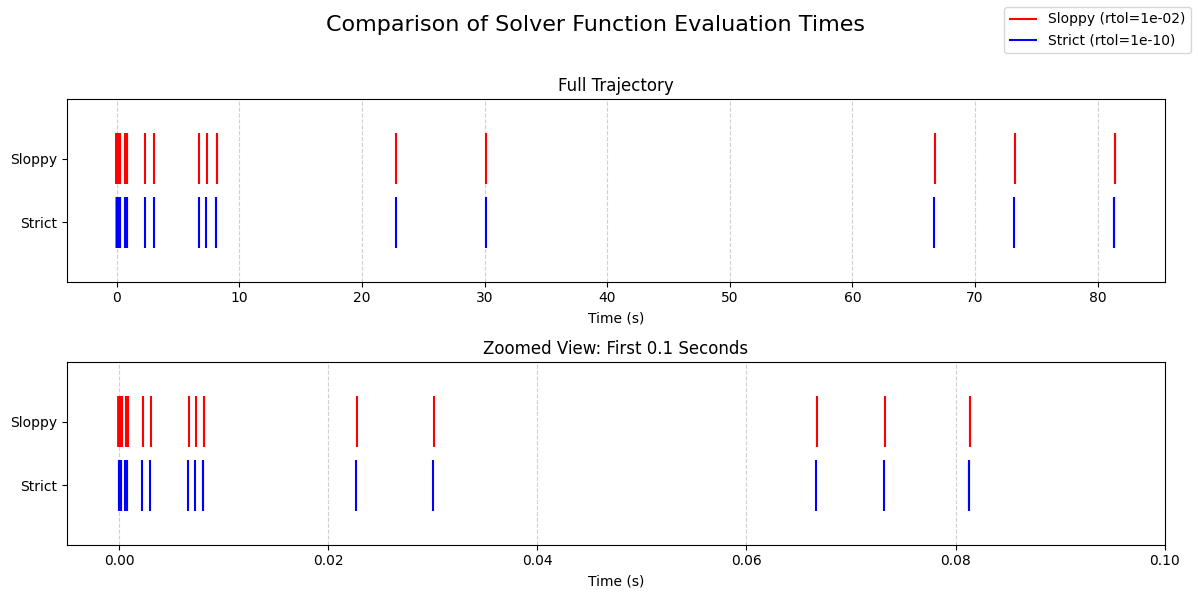

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharey=True)
fig.suptitle('Comparison of Solver Function Evaluation Times', fontsize=16)
# --- Plot 1: Full Trajectory ---
ax1.eventplot(sloppy_eval_times, lineoffsets=1, colors='red', label='Sloppy (rtol=1e-02)', linelengths=0.8)
ax1.eventplot(strict_eval_times, lineoffsets=0, colors='blue', label='Strict (rtol=1e-10)', linelengths=0.8)
ax1.set_title('Full Trajectory')
ax1.set_xlabel('Time (s)')
ax1.grid(axis='x', linestyle='--', alpha=0.6)
# --- Plot 2: Zoomed-in on the start ---
ax2.eventplot(sloppy_eval_times, lineoffsets=1, colors='red', linelengths=0.8)
ax2.eventplot(strict_eval_times, lineoffsets=0, colors='blue', linelengths=0.8)
ax2.set_title('Zoomed View: First 0.1 Seconds')
ax2.set_xlabel('Time (s)')
ax2.set_xlim(-0.005, 0.1)
ax2.grid(axis='x', linestyle='--', alpha=0.6)
# --- Formatting ---
# Set shared y-axis labels
plt.yticks([0, 1], ['Strict', 'Sloppy'])
fig.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

# Other engines

In [8]:
def vacuum_chk(engine_name: str, timeit: bool = False, calcStepSizeFeet: float = 1.0, min_altitude: float = -1.0) -> Tuple[float, int, float]:
    config = BaseEngineConfigDict(
        cMinimumVelocity=0,
        cMinimumAltitude=min_altitude,
        cMaxCalcStepSizeFeet=calcStepSizeFeet,
    )
    calc = Calculator(config, engine=engine_name)
    shot = Shot(ammo=Ammo(DragModel(bc=0.759, drag_table=TableG1), Velocity.FPS(launch_velocity_fps)), atmo=Vacuum())
    shot.relative_angle = Angular.Degree(launch_angle_deg)
    hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
    err = check_error(hit, False)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
        return err, evals, speed.average
    return err, evals

## Verlet steps

In [9]:
step = 0.5
while step <= 1000.0:
    err, count, speed = vacuum_chk('verlet_engine', timeit=True, calcStepSizeFeet=step)
    #print(f'Error={err:.8f}ft.  Integration steps: {count}')
    summary.append(('Verlet', step, err, count, speed))
    step *= 4.0
df = pd.DataFrame(summary, columns=['Engine', 'Setting', 'Error (ft)', 'Integration Steps', 'Speed'])
df[df.Engine == 'Verlet']

3.24 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
833 ms ± 61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
202 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.7 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.5 ms ± 656 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.13 ms ± 88.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,Setting,Error (ft),Integration Steps,Speed
6,Verlet,0.5,0.250000,211265,3.241568
7,Verlet,2.0,0.999997,52817,0.833019
8,Verlet,8.0,3.999983,13206,0.201528
9,Verlet,32.0,15.999929,3303,0.049742
10,Verlet,128.0,63.986863,827,0.012491
11,Verlet,512.0,255.755962,208,0.003132


## Euler steps

In [10]:
step = 0.25
while step <= 1000.0:
    try:
        err, count, speed = vacuum_chk('euler_engine', timeit=True, calcStepSizeFeet=step)
    except Exception as e:
        err, count, speed = vacuum_chk('euler_engine', timeit=True, calcStepSizeFeet=step, min_altitude=-1000.0)
    #print(f'Error={err:.8f}ft.  Integration steps: {count}')
    summary.append(('Euler', step, err, count, speed))
    step *= 4.0
df = pd.DataFrame(summary, columns=['Engine', 'Setting', 'Error (ft)', 'Integration Steps', 'Speed'])
df[df.Engine == 'Euler']

9.61 s ± 521 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.56 s ± 244 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
587 ms ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
149 ms ± 9.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.5 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.09 ms ± 460 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,Setting,Error (ft),Integration Steps,Speed
12,Euler,0.25,0.068663,845053,9.609472
13,Euler,1.0,0.274653,211265,2.564502
14,Euler,4.0,1.098616,52816,0.586770
15,Euler,16.0,4.394466,13204,0.148632
16,Euler,64.0,17.577867,3303,0.035522
17,Euler,256.0,70.324302,827,0.009093


## RK4 steps

In [11]:
step = 0.5
while step <= 5000.0:
    err, count, speed = vacuum_chk('rk4_engine', timeit=True, calcStepSizeFeet=step)
    #print(f'Error={err:.8f}ft.  Integration steps: {count}')
    summary.append(('RK4', step, err, count, speed))
    step *= 4.0
df = pd.DataFrame(summary, columns=['Engine', 'Setting', 'Error (ft)', 'Integration Steps', 'Speed'])
df[df.Engine == 'RK4']

1.9 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
522 ms ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
175 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.8 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.62 ms ± 799 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.39 ms ± 324 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
750 μs ± 72.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Setting,Error (ft),Integration Steps,Speed
18,RK4,0.5,0.000003,52817,1.900298
19,RK4,2.0,0.000017,13205,0.522011
20,RK4,8.0,0.000071,3302,0.175401
21,RK4,32.0,0.013124,826,0.036796
22,RK4,128.0,0.243265,207,0.007620
23,RK4,512.0,4.455340,52,0.002388
24,RK4,2048.0,27.466512,13,0.000750


# Summary

The "error" is effectively the vertical error at the distance where the trajectory should be at height=0.

In [12]:
display(df.style.format({'Error (ft)': '{:.12f}'}))

,Engine,Setting,Error (ft),Integration Steps,Speed
0,SciPy,RK23,0.000000000005,23,0.002735
1,SciPy,RK45,0.000000000058,32,0.002592
2,SciPy,DOP853,0.000000000189,77,0.003361
3,SciPy,Radau,0.000000000015,53,0.004366
4,SciPy,BDF,0.000000188476,58,0.006946
5,SciPy,LSODA,0.000000001994,16,0.001953
6,Verlet,0.500000,0.249999957194,211265,3.241568
7,Verlet,2.000000,0.999996673655,52817,0.833019
8,Verlet,8.000000,3.999983183112,13206,0.201528
9,Verlet,32.000000,15.999929420339,3303,0.049742


In [23]:
dfplot = df[(df.Engine != 'SciPy') & (df['Error (ft)'] < 100) & (1e-6 < df['Error (ft)'])]
dfplot

,Engine,Setting,Error (ft),Integration Steps,Speed
6,Verlet,0.5,0.250000,211265,3.241568
7,Verlet,2.0,0.999997,52817,0.833019
8,Verlet,8.0,3.999983,13206,0.201528
9,Verlet,32.0,15.999929,3303,0.049742
10,Verlet,128.0,63.986863,827,0.012491
12,Euler,0.25,0.068663,845053,9.609472
13,Euler,1.0,0.274653,211265,2.564502
14,Euler,4.0,1.098616,52816,0.586770
15,Euler,16.0,4.394466,13204,0.148632
16,Euler,64.0,17.577867,3303,0.035522


## Explanation

We know that Euler integration has intrinsic limitations.  It may be more surprising that the Verlet engine is unable to reach negligible error regardless of how small its steps.  This reveals a fundamental limitation of fixed-step numerical integration and floating-point arithmetic.

The core of the issue lies in the battle between two types of errors:

1.  **Truncation Error:** This is the error introduced by approximating a continuous curve with discrete steps. For Euler, this error is proportional to the step size (`O(h)`). For Verlet, it's proportional to the square of the step size (`O(h^2)`). This is the error we are trying to reduce by making the step size smaller.

2.  **Floating-Point Round-off Error:** This is the error introduced because computers store numbers with finite precision (usually 64-bit floats). Every time we perform a calculation (like adding a tiny velocity change to a large position value), we can lose a little bit of precision.

### The Error "Floor"

Here’s what happens as we decrease the step size (`h`):

-   **Initially (Large `h`):** The Truncation Error is dominant. Making `h` smaller drastically reduces this error, and the total accuracy of our simulation improves significantly.
-   **Eventually (Very Small `h`):** We reach a point of diminishing returns. The Truncation Error is now very small, but the number of calculations we're performing has become enormous. The tiny, cumulative Round-off Error can become significant.
-   **The Floor:** At some point we hit a "floor" where decreasing `h` further actually makes the result *worse*. The increasing Round-off Error begins to overwhelm the decreasing Truncation Error.

This can be visualized as follows:

| Step Size (`h`) | Truncation Error | Round-off Error | Total Error |
| :--- | :--- | :--- | :--- |
| Large | High | Low | High |
| Medium | Medium | Medium | **Minimum** |
| Very Small | Low | High | High |

### Why RK4 and SciPy Succeed

-   **RK4 (Fourth-Order):** The truncation error is proportional to `h^4`. This means it gets incredibly small, very quickly, as `h` decreases. It can achieve a very low truncation error with a relatively modest number of steps, long before the round-off error becomes the dominant problem. It finds that sweet spot at a much lower error level.
-   **SciPy (Adaptive Solvers):** These are even smarter. They don't use a fixed step size. They constantly adjust the step size to be as large as possible while still meeting the requested error tolerance (`rtol`, `atol`). They automatically operate in that "sweet spot," avoiding the waste and round-off accumulation of using an unnecessarily tiny step size everywhere.

## Chart

When we compare error and speed it's easy to see that – at least on this particular scenario – the RK4 engine dominates the Euler and Verlet engines: it doesn't take it long to generate an excellent solution that the other engines can't achieve with orders of magnitude mroe compute, and for any amount of compute it can produce solutions that are orders of magnitude more accurate.

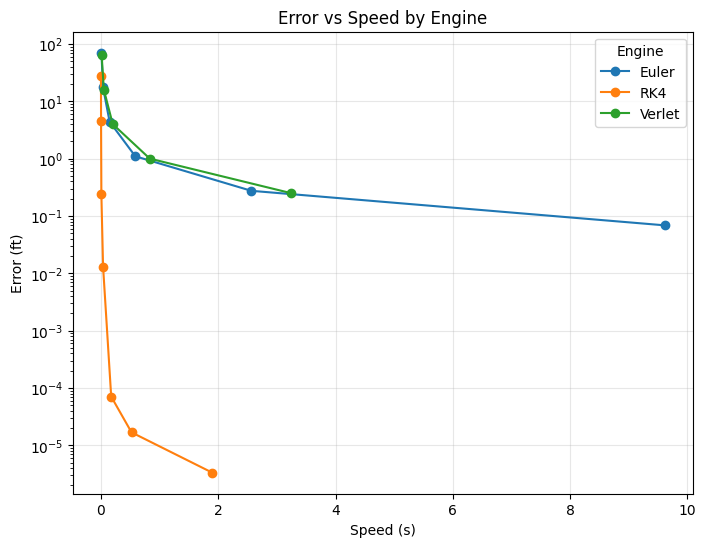

In [21]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
for engine, group in dfplot.groupby('Engine'):
    ax.plot(group['Speed'], group['Error (ft)'], marker='o', label=engine)
ax.set_xlabel('Speed (s)')
ax.set_ylabel('Error (ft)')
ax.set_yscale('log')
ax.set_title('Error vs Speed by Engine')
ax.legend(title='Engine')
ax.grid(True, which='major', alpha=0.3)
plt.show()